### **Sequences and Time Series** 
- Predicting and Forcasting values and patterns over time
- Series of data that changes over time,  for example weather, stock exchange

#### **Example**:
Create and predict synthetic data with time series. Create a time series with trend, seasonality and noise

#### **Import and load data**

In [ ]:
# dependicies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

#### **Plot Series**
- Create plot_series 
- Create trend function for time and slope

In [ ]:
# create plot_series function
def plot_series(time,series, format ="-",start=0, end=None, label=None):
  plt.plot(time[start:end],series[start:end],format,label=label)
  plt.xlabel("Time") # x axis is time
  plt.ylabel("Value") # y axis: value of function at that time
  plt.grid(True)

# create a trend function for time and slope
def trend(time,slope=0):
  return slope*time

#### **lets generate a time series with seasonal pattern**:
- Create seasonal pattern function
- Create seasonality function: Repeats the same pattern at each period
- Add noise function

In [ ]:
# seasonal_pattern function
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# seasonality function: repeats pattern
def seasonality(time, period, amplitude, phase=0):
  season_time =((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

# add noise function
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

#### **Let's create a time series**
- plot time series, figsize 10,6
- baseline, time period =365
- update with noise





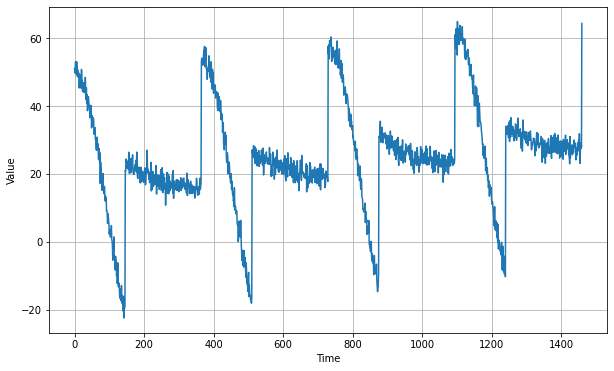

In [ ]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

#### **Summary**
From the graph data trend with time . There is an upward trend and and a downward trend. This can mean that profits for the are negative on the day the sotre is closed, peaking a little the day after, **decaying during the week and peaking on weekends**

#### **Forecasting time series data**
- Split the array array containing the data at index, 1100
- Plot data

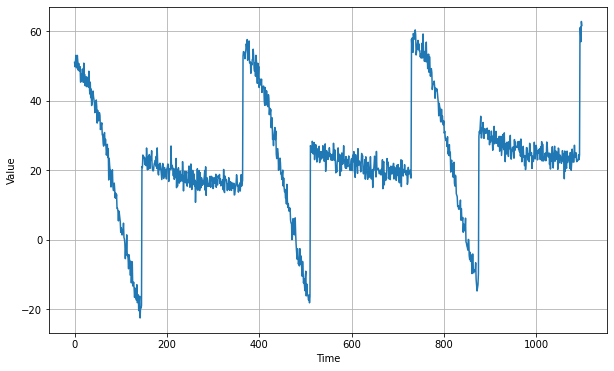

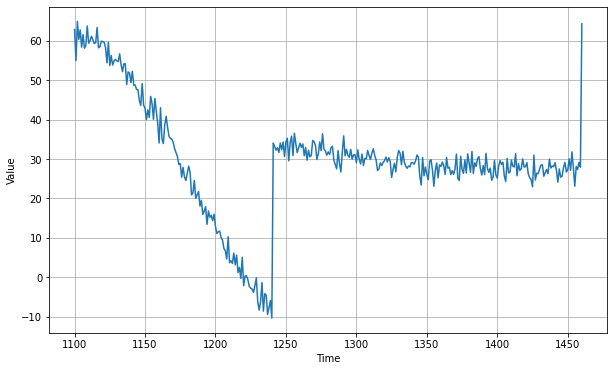

In [ ]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

#### **Summary**
the seasonality is maintained and it is still trending upwards. the both charts are relatively the same, the validation chart is similar bit it is more zoomed in.
- Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
- Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0


#### **Naive Forcast**
If we want to forecast the price for the next day, we can simply take the last day value and estimate the same value for the next day. Such forecasting technique which assumes that the next expected point is equal to the last observed point is called **Naive Method**
- predict the value at time period plus one
- copy the training data at time -1



In [ ]:
# copy training data at time -1
naive_forecast = series[split_time - 1:-1]

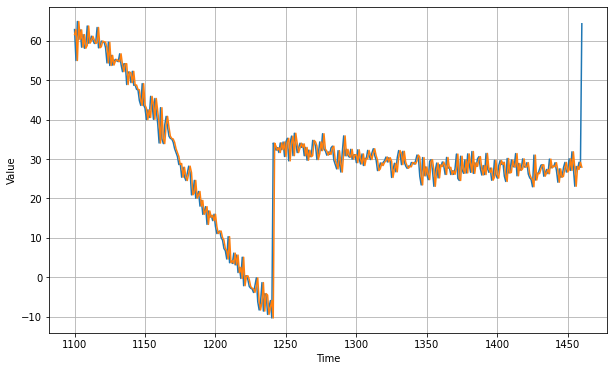

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

#### **Summary**
Similar as above, but with forcast overlay

#### Lets Zoom in on the start of the validation period:
- start:0 , end :150


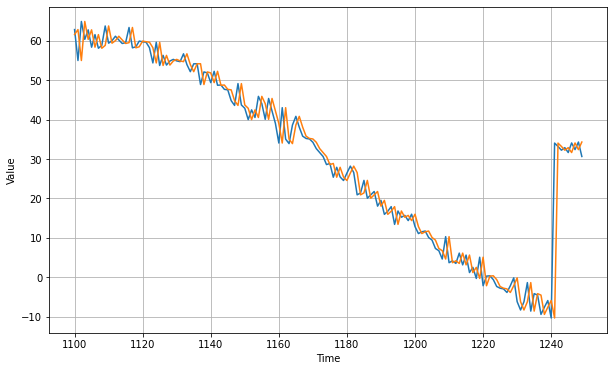

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=150)


#### **Summary**
Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped **1 unit (blue line) 'after'** series

#### **Show Baseline**
Now let's compute the **mean squared error** and the **mean absolute error** between the forecasts and the predictions in the validation period:
- mean squared error for **naive forcast**

In [ ]:
# mean square error and mean absolute error for naive forcast
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

17.785322
2.554528


#### **Create function to calculate movine average**:
- Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast
- plot graph

In [ ]:
# moving_average function
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

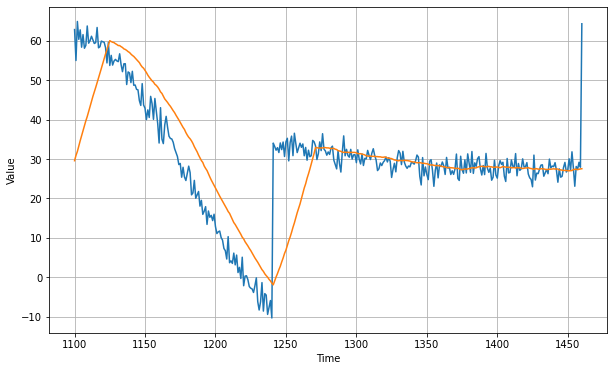

In [ ]:
# moving average
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# plot
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

#### **Summary**
- Chart with time series from 1100->1450+ on X
- Time series plotted
- Moving average(orange line) plotted over it

#### **Show Baseline**
Now let's compute the **mean squared error** and the **mean absolute error** for the **moving average**

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

94.57754
6.3656044


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.